#### Utils

In [1]:
from scipy.stats import poisson,norm
from math import log
from scipy.integrate import simpson
from scipy.optimize import minimize
from functools import partial
from scipy.integrate import quad
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumulative_trapezoid

def model_poisson(n,s,b):
    return poisson(s+b).pmf(n)

def prior_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

def constraint_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

# prior_b and constraint_b practically equal, conceptually different
def model_constraint_bayes(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*prior_b(b,bbar,sigmab)
    
def model_constraint_freq(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*constraint_b(bbar,b,sigmab)

def model_poisson_2d(n,x):
    s = x[0]
    b = x[1]
    return model_poisson(n,s,b)
    
def model_constraint_2d_freq(n,x,bbar,sigmab):
    s = x[0]
    b = x[1]
    return model_constraint_freq(n,s,b,bbar,sigmab)

def nll(model,n,s,b,**kwargs):
    return -np.log(model(n,s,b,**kwargs))

def nll_2d(model,n,x,**kwargs):
    return -np.log(model(n=n,x=x,**kwargs))

def integral_2d(f,x,y):
    zz = f(x.reshape(-1,1),y.reshape(1,-1))
    return simpson([simpson(zz_y,y) for zz_y in zz],x) 
    
def posterior(model,n,b=None,s=np.linspace(0,10,101),profile_b=False,TwoD = False,**kwargs):
    if type(b) is int or type(b) is float: # fixed b
        integralmodel = quad(partial(model,n,b=b,**kwargs),0,np.inf)[0]
        return model(n,s,b,**kwargs)/integralmodel
    else: # b not fixed
        if profile_b: # optimise b
            post = []
            for s_i in s:
                res=minimize(partial(nll,model,n,s_i,**kwargs),x0=(3,),bounds=[(0,np.inf)])
                optimalb = res.x[0]
                post.append(model(n=n,s=s_i,b=optimalb,**kwargs))
            post = np.array(post)
            integralmodel = simpson(post,s)
            return post/integralmodel
        else: # integrate b
            post = []
            integral = integral_2d(partial(model,n,**kwargs),s,b)
            if TwoD: # Posterior 2D (s,b)
                return model(n,s = s.reshape(1,-1),b = b.reshape(-1,1),**kwargs)/integral
            else: # Posterior 1D (s) / integrate b
                integral_b = simpson(model(n,s.reshape(-1,1),b.reshape(1,-1),**kwargs),b,axis=1)
                return integral_b/integral

def testStatistic(model,n,s,b,bestNLL,**kwargs):
    return 2*(nll(model=model,n=n,s=s,b=b,**kwargs)-bestNLL)

In [2]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)


#### Python

In [13]:
from scipy.stats import chi2
from random import gauss
expected_n = 200
expected_bbar = 150
sigmab = 30
Ntoys = 10000
upper_limits = []
limit = chi2(1).ppf(0.9) # 95% one sided CL
s = np.linspace(0.5,150,20)
# plt.figure(figsize=(50,25))

for i in range(Ntoys):
    n = np.random.poisson(expected_n, 1)
    bbar = gauss(expected_bbar, sigmab)    
    res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(2,3),bounds=[(0,np.inf),(0,np.inf),])
    bestNLL = res.fun
    t = np.array([])
    for si in s:
        res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(3,),bounds=[(0,np.inf),])
        t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
    # plt.subplot(13,10,i+1)
    # plt.plot(s,t,label=r'$\sigma_b=%.2f$'%sigmab,lw=1)
    idx = (t>limit).argmax()
    upper_limit = 0.5*(s[idx]+s[idx-1])
    # print('pper limit = %.2f'%(upper_limit))
    upper_limits.append(upper_limit)
    if (i%100 == 0):
        print(i)
    # plt.vlines(upper_limit,0,limit,lw=1)
# plt.xlabel('s',fontsize=15)
# plt.axhline(limit,color='black',lw=1)
# plt.legend(loc='best')

0


/tmp/ipykernel_22770/1736631009.py:38: RuntimeWarning: divide by zero encountered in log
  return -np.log(model(n,s,b,**kwargs))


100
200
300
400
500


/tmp/ipykernel_22770/1736631009.py:41: RuntimeWarning: divide by zero encountered in log
  return -np.log(model(n=n,x=x,**kwargs))


600
700
800
900
1000


In [7]:
from scipy.stats import chi2
n = 20
bbar = 15
limit = chi2(1).ppf(0.9) # 95% one sided CL
s = np.linspace(0,40,10000)
for sigmab in [9.5]:
    res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(2,3),bounds=[(0,np.inf),(0,np.inf),])
    bestNLL = res.fun
    t = np.array([])
    for si in s:
        res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(3,),bounds=[(0,np.inf),])
        t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
    p = plt.plot(s,t,label=r'$\sigma_b=%.2f$'%sigmab,lw=1)
    idx = (t>limit).argmax()
    upper_limit = 0.5*(s[idx]+s[idx-1])
    print('sigmab = %.2f, upper limit = %.2f'%(sigmab,upper_limit))
    plt.vlines(upper_limit,0,limit,lw=1,color=p[0].get_color())
plt.xlabel('s',fontsize=15)
plt.axhline(limit,color='black',lw=1)
plt.legend(loc='best')

## Esercizio 2

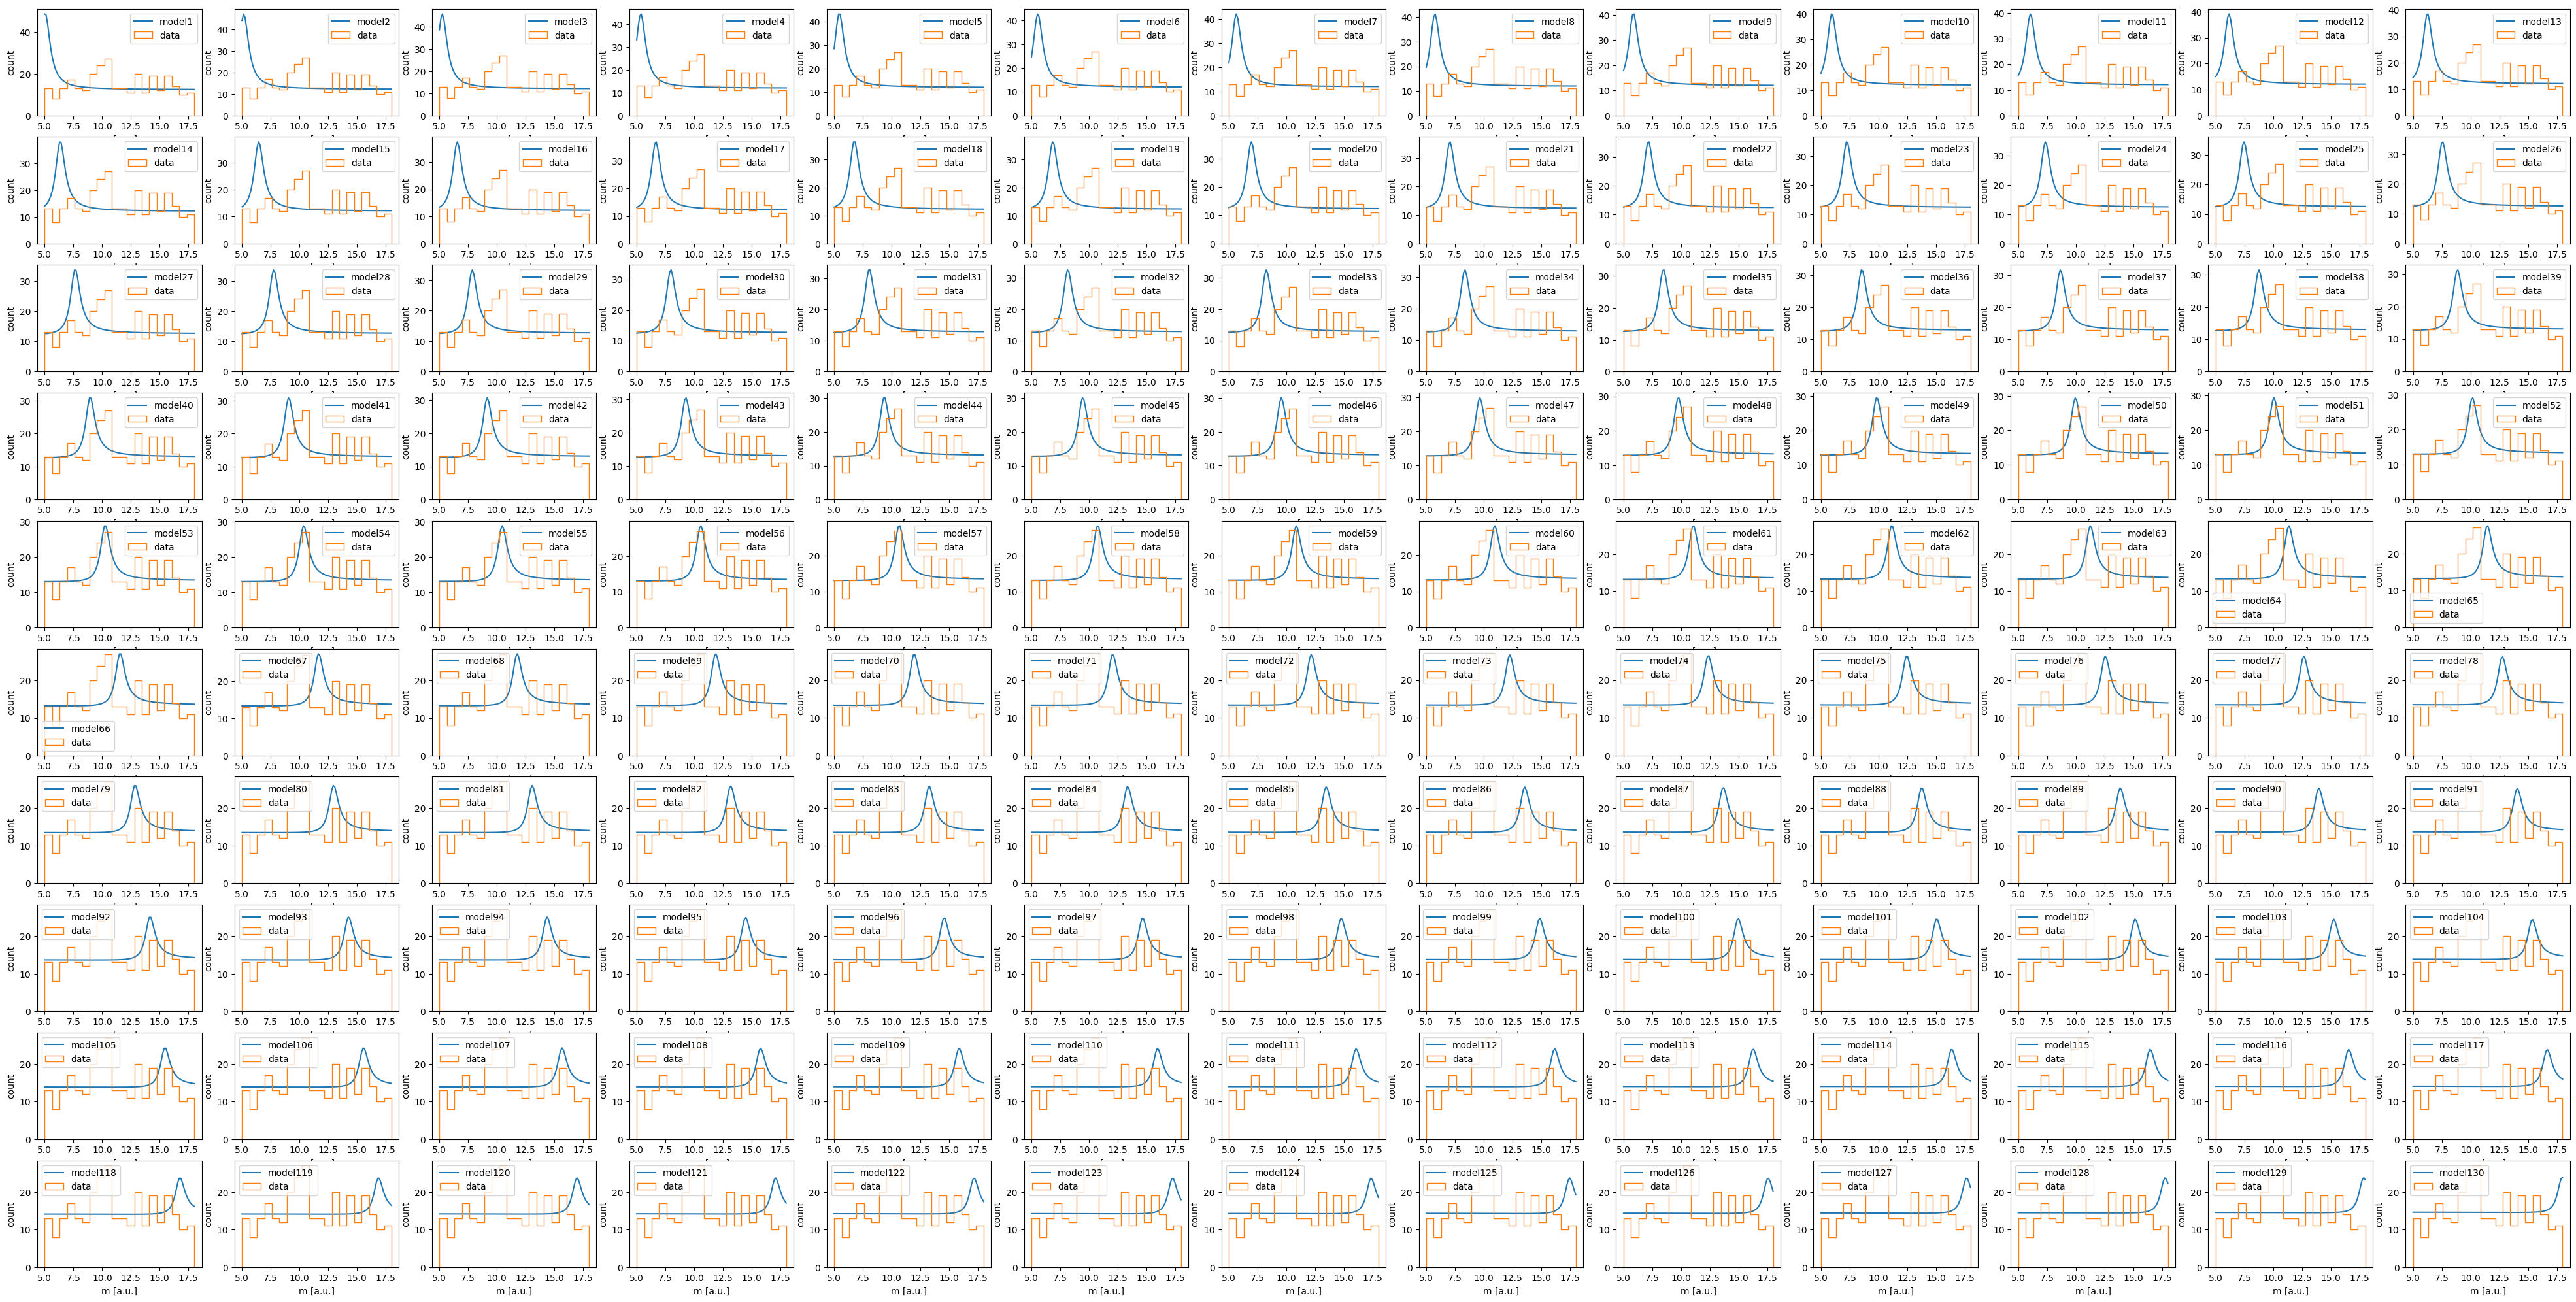

In [40]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simpson
from scipy.stats import chi2,norm
from scipy.optimize import minimize
np.random.seed(276884)
#np.random.seed(10)

def model(x,pars,m0):
    a = pars[0]
    theta = np.pi/2.-0.3
    m0 = m0
    gamma = 1
    xint = np.linspace(5,18,10001)
    val_model = lambda x: np.abs(1+a*np.exp(1j*theta)/((x**2-(m0)**2)+1j*m0*gamma))**2
    if (type(a) is not np.ndarray) and type(theta) is not np.ndarray:
        integral = simpson(val_model(xint),xint)
        return val_model(x)/integral
    else:
        a = a.reshape(-1,1)
        theta = theta.reshape(-1,1)
        integral = simpson(val_model(xint),xint,axis=1).reshape(-1,1)
        return val_model(x)/integral    
    #return 1+(np.power(a,2)+2*a*np.sin(theta)*m0*gamma+2*a*(np.power(x,2)-np.power(m0,2))*np.cos(theta))/( np.power(np.power(x,2)-np.power(m0,2),2)+np.power(m0*gamma,2) )

data = np.loadtxt("data.txt", usecols=0)

ndata = 300

masses = np.arange(5, 18, 0.1)
i = 1
plt.figure(figsize=(50,25))
for m0 in masses:
    thetaval = np.pi/2.-0.3
    aval = 5
    x = np.linspace(5,18,101)
    ymodel = model(x,[aval,thetaval],m0)

    len(data)
    nbins = 20
    plt.subplot(10, 13, i)
    plt.plot(x,ymodel*ndata*(x.max()-x.min())/nbins,label='model' + str(i))
    plt.hist(data,bins=np.linspace(x.min(),x.max(),nbins+1),histtype='step',label='data')
    plt.xlabel('m [a.u.]')
    plt.ylabel('count')
    plt.legend(loc='best')
    i+= 1

In [37]:
from scipy.optimize import curve_fit

def breit_wigner(x, a):
    gamma = 1
    theta = np.pi/2.-0.3
    return (np.abs(1+a*np.exp(1j*theta)/((x**2-(m0)**2)+1j*m0*gamma))**2 ) 

x = np.linspace(5, 18, 300)
a_values = []
b_values = []

for m0 in masses:
    parameters, covariance = curve_fit(breit_wigner, x, data)
    # print("m0 = " + str(m0) + ", a = " + str(parameters[0]))
    a_values.append(parameters[0])
    # b_values.append(parameters[1])

In [66]:
a_values = []
t_null = []
t = []

def nll(data,model,pars):
    log = np.log(model(data,pars,m0))
    if len(log.shape)==1: return -np.sum(np.log(model(data,pars,m0)))
    else: return -np.sum(np.log(model(data,pars,m0)),axis=1)

i = 0

for m0 in masses:
    fit = minimize(lambda pars: nll(data, model, pars), x0=[aval, m0], bounds=((-np.inf, +np.inf),(m0,m0)))
    a_values.append(fit.x[0])
    t_null.append(1)
    t.append(-2 * np.log(1./13.) -2 * nll(data,model,[a_values[i],m0]))
    i+= 1


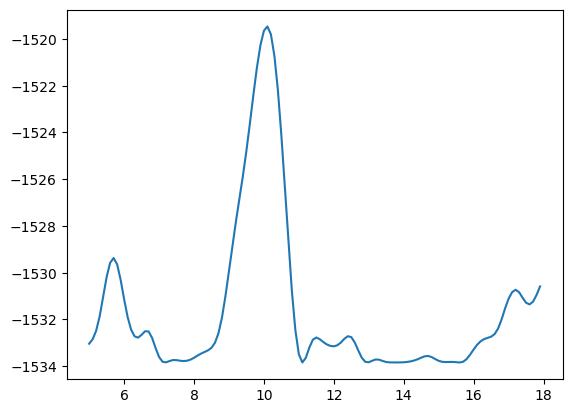

In [67]:
plt.figure()
plt.plot(masses, t)

In [70]:
t_min = np.argmax(t)
m0_best = masses[t_min]

print(m0_best)
print(t_min)

10.099999999999982
51


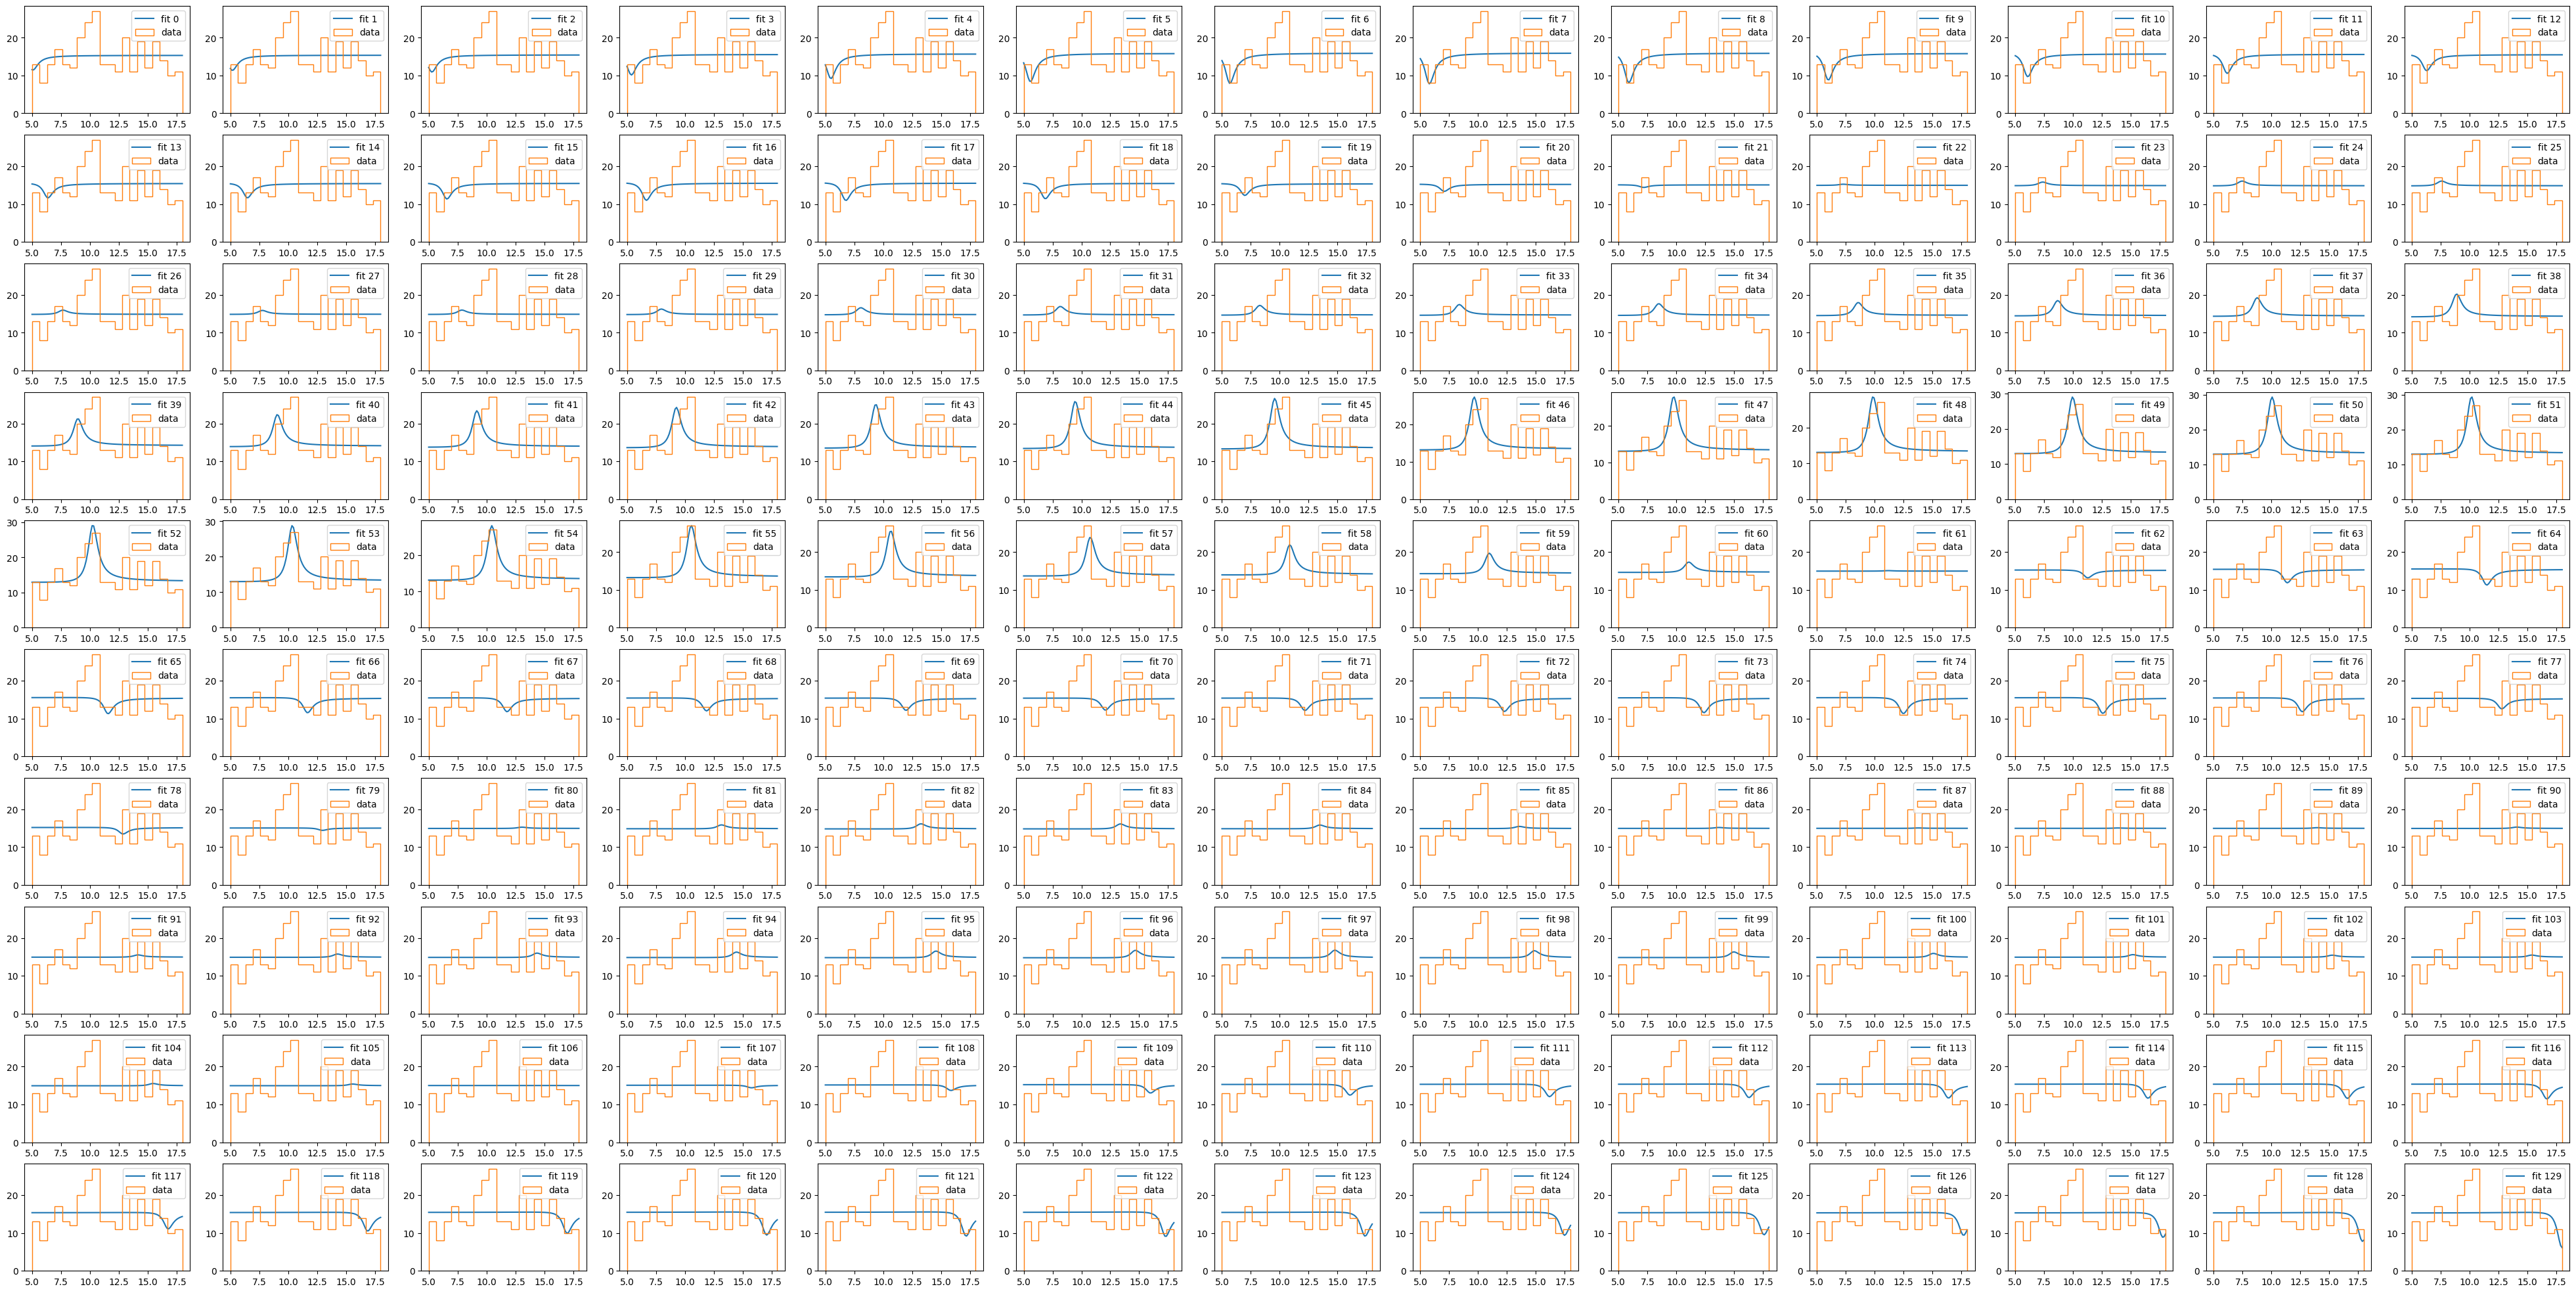

In [69]:
plt.figure(figsize=(50,25))
i = 0

for m0 in masses:
    plt.subplot(10,13, i+1)
    ymodel = model(x,[a_values[i]],m0)
    plt.plot(x,ymodel*ndata*(x.max()-x.min())/nbins,label='fit ' + str(i))
    plt.hist(data, bins=np.linspace(x.min(),x.max(),nbins+1),histtype='step',label='data')
    plt.legend()
    i+=1